<a href="https://colab.research.google.com/github/ankitstar01/ml_test/blob/master/seq_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import shutil
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense,Embedding,LSTM,Input
from keras.optimizers import Adam,SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

shutil.copy('/content/drive/My Drive/Colab Notebooks/datasets/robert_frost.txt','/content/robert_frost.txt')
shutil.copy('/content/drive/My Drive/Colab Notebooks/wordvec/glove.zip','/content/glove.zip')

MAX_SEQ_LEN=100
MAX_VOCAB_SIZE=3000
EMBEDDING_DIM=50
VALIDATION_SPLIT=0.2
BATCH_SIZE=128
EPOCHS=300
LATEN_DIM=25

In [ ]:
#loading the data

input_data=[]
output_data=[]

for line in open('./robert_frost.txt'):
    line=line.rstrip()
    if not line:
        continue
    
    input_line='<sos> '+line
    output_line=line+' <eos>'
    
    input_data.append(input_line)
    output_data.append(output_line)
all_line=input_data+output_data
all_line

['<sos> Two roads diverged in a yellow wood,',
 '<sos> And sorry I could not travel both',
 '<sos> And be one traveler, long I stood',
 '<sos> And looked down one as far as I could',
 '<sos> To where it bent in the undergrowth;',
 '<sos> Then took the other, as just as fair,',
 '<sos> And having perhaps the better claim',
 '<sos> Because it was grassy and wanted wear,',
 '<sos> Though as for that the passing there',
 '<sos> Had worn them really about the same,',
 '<sos> And both that morning equally lay',
 '<sos> In leaves no step had trodden black.',
 '<sos> Oh, I kept the first for another day!',
 '<sos> Yet knowing how way leads on to way',
 '<sos> I doubted if I should ever come back.',
 '<sos> I shall be telling this with a sigh',
 '<sos> Somewhere ages and ages hence:',
 '<sos> Two roads diverged in a wood, and I,',
 '<sos> I took the one less traveled by,',
 '<sos> And that has made all the difference.',
 '<sos> Whose woods these are I think I know.',
 '<sos> His house is in the

In [ ]:
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE,filters='')
tokenizer.fit_on_texts(all_line)
input_seq=tokenizer.texts_to_sequences(input_data)
output_seq=tokenizer.texts_to_sequences(output_data)
max_seq_len=max(len(s) for s in input_seq)
print('Max Seq Len {}'.format(max_seq_len))

Max Seq Len 12


In [ ]:
#word to index mapping
word2idx=tokenizer.word_index
print('total unique tokens %s '%len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

max_seq_len=min(MAX_SEQ_LEN,max_seq_len)
input_seq=pad_sequences(input_seq,maxlen=max_seq_len,padding='post')
output_seq=pad_sequences(output_seq,maxlen=max_seq_len,padding='post')
print('shape of input tensor : ',input_seq.shape)

total unique tokens 3056 
shape of input tensor :  (1436, 12)


In [ ]:
# import requests

# url = 'http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'
# r = requests.get(url, stream=True)
# open('glove.zip', 'wb').write(r.content)
!unzip ./glove.zip

Archive:  ./glove.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
print('loading word vector')
word2vec={}
with open(os.path.join('./glove.6B.%sd.txt'%EMBEDDING_DIM)) as f:
    for line in f:
        value=line.split()
        word=value[0]
        vec=np.asarray(value[1:],dtype='float32')
        word2vec[word]=vec
print('found %s word vectors'%len(word2vec))
word2idx['<eos>']

loading word vector
found 400000 word vectors


2

In [ ]:
print('filling pretrained embedding')
num_words=min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx.items():
  if i<MAX_VOCAB_SIZE:
    embedding_vec=word2vec.get(word)
    if embedding_vec is not None:
      embedding_matrix[i]=embedding_vec

filling pretrained embedding


In [ ]:
one_hot_targets=np.zeros((len(input_seq),max_seq_len,num_words))
for i,targets in enumerate(output_seq):
  for t,word in enumerate(targets):
    if word>0:
      one_hot_targets[i,t,word]=1

In [ ]:
embedding_layer=Embedding(num_words
                          ,EMBEDDING_DIM,
                          weights=[embedding_matrix])
  
# building the model

print("building model")
input_=Input(shape=[max_seq_len,])
initial_h=Input(shape=[LATEN_DIM,])
initial_c=Input(shape=[LATEN_DIM,])
x=embedding_layer(input_)
lstm=LSTM(LATEN_DIM,return_sequences=True,return_state=True)
x,_,_=lstm(x,[initial_h,initial_c])
dense=Dense(num_words,activation='softmax')
output=dense(x)
model=Model([input_,initial_h,initial_c],output)
model.compile(
     loss='categorical_crossentropy',
     optimizer=Adam(lr=0.01),
     metrics=['accuracy']
)



building model


training the model
Epoch 1/300
9/9 [==============================] - 2s 176ms/step - loss: 5.4040 - accuracy: 0.0376 - val_loss: 5.0947 - val_accuracy: 0.0116
Epoch 2/300
9/9 [==============================] - 1s 130ms/step - loss: 4.6577 - accuracy: 0.0597 - val_loss: 4.8318 - val_accuracy: 0.0833
Epoch 3/300
9/9 [==============================] - 1s 128ms/step - loss: 4.3849 - accuracy: 0.0833 - val_loss: 4.9206 - val_accuracy: 0.0833
Epoch 4/300
9/9 [==============================] - 1s 126ms/step - loss: 4.3127 - accuracy: 0.0833 - val_loss: 4.9202 - val_accuracy: 0.0833
Epoch 5/300
9/9 [==============================] - 1s 125ms/step - loss: 4.2564 - accuracy: 0.0833 - val_loss: 4.9548 - val_accuracy: 0.0833
Epoch 6/300
9/9 [==============================] - 1s 127ms/step - loss: 4.2064 - accuracy: 0.0833 - val_loss: 4.9172 - val_accuracy: 0.0833
Epoch 7/300
9/9 [==============================] - 1s 127ms/step - loss: 4.1409 - accuracy: 0.0833 - val_loss: 4.8671 - val_accuracy: 0

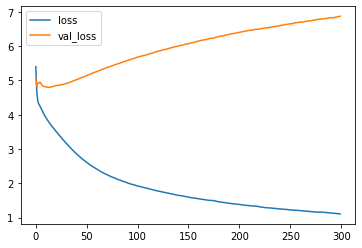

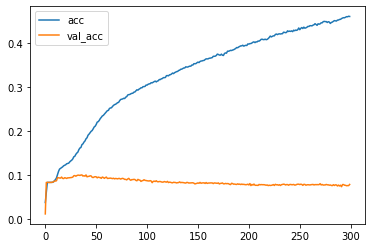

In [ ]:
print('training the model')
z=np.zeros((len(input_seq),LATEN_DIM))
r=model.fit([input_seq,z,z],one_hot_targets
             ,batch_size=BATCH_SIZE,
             epochs=EPOCHS,             
            validation_split=VALIDATION_SPLIT)
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()


In [ ]:
input2=Input(shape=(1,))
x=embedding_layer(input2)
x,h,c=lstm(x,initial_state=[initial_h,initial_c])
output2=dense(x)
sampling_model=Model([input2,initial_h,initial_c],[output2,h,c])

In [ ]:
idx2word={v:k for k,v in word2idx.items()}
def sample_line():
  np_input=np.array([[word2idx['<sos>']]])
  h=np.zeros([1,LATEN_DIM])
  c=np.zeros([1,LATEN_DIM])

  eos=word2idx['<eos>']

  ouput_sentence = []

  for _ in range(max_seq_len):
    o,h,c =sampling_model.predict([np_input,h,c])

    probs=o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0]=0
    probs/=probs.sum()
    idx=np.random.choice(len(probs),p=probs)

    if idx == eos:
      break
    ouput_sentence.append(idx2word.get(idx, '<WTF %s>'%idx))

    np_input[0,0]=idx

    return ' '.join(ouput_sentence)

while True:
  for _ in range(4):
    print(sample_line())

  ans=input("----generate another(y/n)----")
  if ans and ans[0].lower().startswith('n'):
    break


faster
now
one
was
----generate another(y/n)----y
to
and
the
and
----generate another(y/n)----n
